# Exam set 
## date : 19/01 - 2023


### Import of libraries and external functions

In [252]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iminuit import Minuit
from scipy import stats
import math 
import sympy as sp
from IPython.core.display import Latex
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import sys

In [253]:
sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import  nice_string_output, add_text_to_ax 

In [254]:
sys.path.append('My_Functions')
from My_Functions import *
plot_pref()
r = np.random
r.seed(16)

## Problem 1 Distributions and probabilities

In [255]:
# 1.1
# Two gaussians with mu = 50, sigma = 20

#1.1.1
# Fraction between [55, 65] for test A
# Simply use stats with difference between cdf for 65 and 55
sigma = 20
mu = 50

frac = stats.norm.cdf(65, loc = mu, scale = sigma) - stats.norm.cdf(55,  loc = mu, scale = sigma)
print('The fraction scoring between 55 and 65 is: ', frac)

The fraction scoring between 55 and 65 is:  0.17466632194020804


In [256]:
#We verify using numerical experiment
N_exp = 100
N = 10000
fracs = np.zeros(N_exp)
for i in range(N_exp):
    x = r.normal(mu, sigma, N)
    fracs[i] = np.sum((x >= 55) & (x <= 65))/N

print('The average fraction is: ', np.mean(fracs), ' with standard deviation: ', np.std(fracs))

The average fraction is:  0.174482  with standard deviation:  0.0040530822838921


In [257]:
#1.1.2
#The uncertainty on the mean is sigma/sqrt(N)
#For 120 tests of B the uncertainty is
print('The uncertainty on the mean of test B is: ', sigma/np.sqrt(120))


The uncertainty on the mean of test B is:  1.8257418583505538


The fraction where both A and B are above 60 is:  0.17977299999999996 +/- 0.003485193107992726


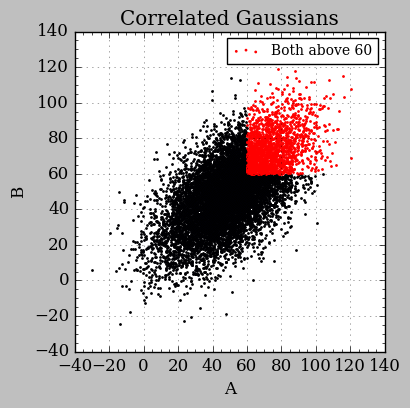

In [258]:
#1.1.3
#The correlation between the two test is rho = 0.6
rho = 0.6
#We produce a correlation matrix
cov = np.array([[sigma**2, rho*sigma**2], [rho*sigma**2, sigma**2]])
#We solve the problem nummerically 
#First we produce a grid of points with the correct covariance

N_exp = 100
N = 10000
fracs = np.zeros(N_exp)
for i in range(N_exp):
    num_cor = r.multivariate_normal([mu, mu], cov,  size =(N))
    A, B = num_cor[:,0], num_cor[:,1]
    fracs[i] = np.sum((A > 60) & (B > 60))/N

num_cor = r.multivariate_normal([mu, mu], cov,  size =(N))
A, B = num_cor[:,0], num_cor[:,1]

fig, ax = plt.subplots(1,1, figsize = (4,4))
#ax.hist2d(A, B, bins = 100, cmap = 'viridis')

mask = (A > 60) & (B > 60)
ax.scatter(A[~mask], B[~mask], s = 1)
ax.scatter(A[mask], B[mask], s = 1, color = 'r', label = 'Both above 60')
ax.legend(fontsize = 10)
ax.set_xlabel('A')
ax.set_ylabel('B')
ax.set_title('Correlated Gaussians')

#Fraction where both A and B are above 60
frac = np.sum((A > 60) & (B > 60))/N_exp
print('The fraction where both A and B are above 60 is: ', np.mean(fracs), '+/-', np.std(fracs))

#fig.savefig('figures/113scatter.png')

In [259]:
#1.2
#On average 40% win the game
#20 random persons play the game 
#Binomial distribution with n = 20 and p = 0.4
#the chance of 11 or more winning is sf of the binomial distribution after 10
chance = stats.binom.sf(10, 20, 0.4)
print('The chance of 11 or more winning is: ', chance)
#The uncertainty of the fraction is sqrt(f(1-f)/n)
print('The uncertainty of the fraction is: ', np.sqrt(chance*(1-chance)/20))

The chance of 11 or more winning is:  0.12752124614721688
The uncertainty of the fraction is:  0.07458537991063591


In [260]:
#We simulate the problem numerically
N_exp = 100
N = 10000
n = 20
p = 0.4
fracs = np.zeros(N_exp)
for i in range(N_exp):
    wins = r.binomial(n, p, N)
    fracs[i] = np.sum(wins >= 11)/N
print('The fraction of 11 or more winning is: ', np.mean(fracs), '+/-', np.std(fracs))


The fraction of 11 or more winning is:  0.127491 +/- 0.003141817785932214


## Problem 2 Error propagation

In [261]:
#2.1

#First we define the necessary equations

x, y = sp.symbols('x y')
err_symbols = np.array(sp.symbols('sigma_x sigma_y'))
z_1 = x*y*sp.exp(-y)
z_2 = (y+1)**3/(x+1)

values = np.array([1.033, 0.07])
errors = np.array([0.014, 0.23])

non_correlated = np.array([[1, 0] , [0, 1]])

prop_1 = Error_Prop(z_1, np.array([x, y]), err_symbols, values, errors, non_correlated)

#2.1.1
# Which variable contributes most to the uncertainty on z_1
# can be found by looking at the contributions to the variance of z_1

# Test to see if the errors are calculated correctly
display(prop_1.get_propEq())
#We also print the error
print('The error on z_1 is: ', prop_1.get_error())
#Each contribution
contributions_1 = prop_1.get_contributions()
print('The contribution of x to the variance is: ', contributions_1[0])
print('The contribution of y to the variance is: ', contributions_1[1])
print('The largest contribution is from y')

sqrt(sigma_x**2*y**2*exp(-2*y) + sigma_y**2*(-x*y*exp(-y) + x*exp(-y))**2)

The error on z_1 is:  0.20602255265570826
The contribution of x to the variance is:  8.349316492770134e-07
The contribution of y to the variance is:  0.04244445727112481
The largest contribution is from y


In [262]:
print('z1 =', values[0]*values[1]*sp.exp(-values[1]))
print('z2 =', (values[1]+1)**3/(values[0]+1))

z1 = 0.0674213971173991
z2 = 0.6025789473684211


In [263]:
#2.1.2
#Now with correlated errors
correlated = np.array([[1, 0.4] , [0.4, 1]])
prop_1_corr = Error_Prop(z_1, np.array([x, y]), err_symbols, values, errors, correlated)
prop_2_corr = Error_Prop(z_2, np.array([x, y]), err_symbols, values, errors, correlated)

#First we display the equations
display(prop_1_corr.get_propEq())
display(prop_2_corr.get_propEq())

#Then we calculate the errors
print('The error on z_1 is: ', prop_1_corr.get_error())
print('The error on z_2 is: ', prop_2_corr.get_error())

#We see that the error on z_2 is smaller than when uncorrelated where it is
prop_2 = Error_Prop(z_2, np.array([x, y]), err_symbols, values, errors, non_correlated)
print('The error on z_2 when uncorrelated is: ', prop_2.get_error())

sqrt(1.0*sigma_x**2*y**2*exp(-2*y) + 0.8*sigma_x*sigma_y*y*(-x*y*exp(-y) + x*exp(-y))*exp(-y) + 1.0*sigma_y**2*(-x*y*exp(-y) + x*exp(-y))**2)

3.0*sqrt(0.111111111111111*sigma_x**2*(y + 1)**6/(x + 1)**4 - 0.266666666666667*sigma_x*sigma_y*(y + 1)**5/(x + 1)**3 + sigma_y**2*(y + 1)**4/(x + 1)**2)

The error on z_1 is:  0.20638772380872863
The error on z_2 is:  0.38693780437122366
The error on z_2 when uncorrelated is:  0.3886011031756979


The correlation between z_1 and z_2 is:  0.9211539383884714 +/- 0.0016224307396960275


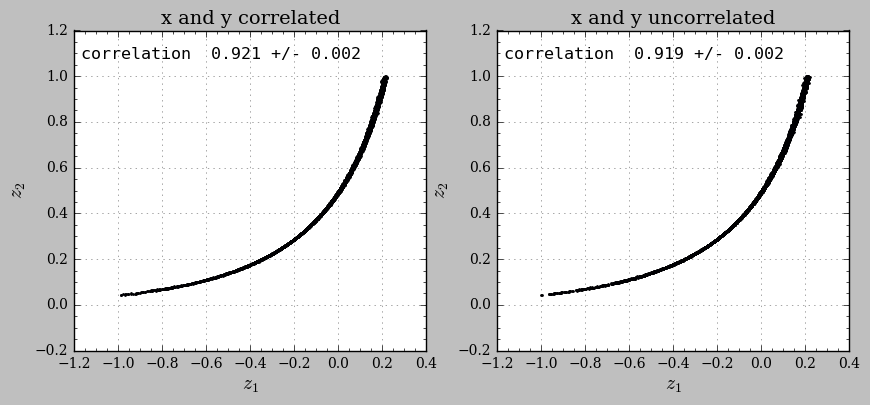

In [264]:
#2.1.3
#We define the covariance matrix
cov = np.array([[0.014**2, 0.014*0.23*0.4], [0.014*0.23*0.4, 0.23**2]])
#We solve the problem nummerically
N_exp = 100
N = 10000
correlations = np.zeros(N_exp)
correlations_2 = np.zeros(N_exp)
for i in range(N_exp):
    num_cor = r.multivariate_normal(values, cov,  size =(N))
    x_exp, y_exp = num_cor[:,0], num_cor[:,1]
    z_1_exp = x_exp*y_exp*np.exp(-y_exp)
    z_2_exp = (y_exp+1)**3/(x_exp+1)
    mask = (z_1_exp >= -1)*(z_1_exp <= 1)*(z_2_exp >= -1)*(z_2_exp <= 1)
    correlations[i] = np.corrcoef(z_1_exp[mask], z_2_exp[mask])[0,1]

    #In case x and y are uncorrelated
    num_uncor = r.multivariate_normal(values, np.diag(errors**2),  size =(N))
    x_2, y_2 = num_uncor[:,0], num_uncor[:,1]
    z_1_2 = x_2*y_2*np.exp(-y_2)
    z_2_2 = (y_2+1)**3/(x_2+1)
    mask_2 = (z_1_2 >= -1)*(z_1_2 <= 1)*(z_2_2 >= -1)*(z_2_2 <= 1)
    correlations_2[i] = np.corrcoef(z_1_2[mask_2], z_2_2[mask_2])[0,1]


print('The correlation between z_1 and z_2 is: ', np.mean(correlations), '+/-', np.std(correlations))
#We plot the last experiment
fig, ax = plt.subplots(1,2, figsize = (10,4))   
ax[0].scatter(z_1_exp[mask], z_2_exp[mask], s = 1)
ax[0].tick_params(labelsize = 10)
ax[0].set_xlabel(r'$z_1$', fontsize = 14)
ax[0].set_ylabel(r'$z_2$', fontsize = 14)
ax[0].set_title('x and y correlated', fontsize = 14)

d_1 = {
    'correlation': [np.mean(correlations), np.std(correlations)]}
text_1 = nice_string_output(d_1, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text_1, ax[0], fontsize=12)

ax[1].scatter(z_1_2[mask_2], z_2_2[mask_2], s = 1)
ax[1].tick_params(labelsize = 10)
ax[1].set_xlabel(r'$z_1$', fontsize = 14)
ax[1].set_ylabel(r'$z_2$', fontsize = 14)
ax[1].set_title('x and y uncorrelated', fontsize = 14)

d_2 = {
    'correlation': [np.mean(correlations_2), np.std(correlations_2)]}
text_2 = nice_string_output(d_2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.95, text_2, ax[1], fontsize=12)


#fig.savefig('figures/213correlation.png')



In [265]:
#2.2
num = np.linspace(1, 5, 5)
obs = np.array([5.5, 5.61, 4.88, 5.07, 5.26])
unc = np.array([0.1, 0.21, 0.15, 0.14, 0.13])

#2.2.1
#The combined result can be found using weighted mean

w_mean = np.sum(obs/unc**2)/np.sum(1/unc**2)
w_unc = np.sqrt(1/np.sum(1/unc**2))
print('The weighted mean is: ', w_mean, ' with uncertainty: ', w_unc)

The weighted mean is:  5.279305828390056  with uncertainty:  0.06005034708204228


In [266]:
#2.2.2
#To check whether the results are consistent we use a chi2 test with constant function


In [267]:
def constant(x, a):
    return a

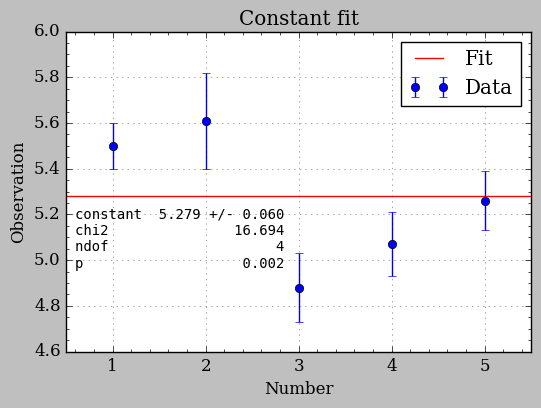

In [268]:
chi2_constant = Chi2Regression(constant, num, obs, unc)
minuit = Minuit(chi2_constant, a = 1)
minuit.errordef = 1
minuit.migrad()

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.errorbar(num, obs, yerr = unc, fmt = 'o', label = 'Data')
ax.set(xlabel = 'Number', ylabel = 'Observation', title = 'Constant fit', xlim = (0.5, 5.5))
ax.axhline(minuit.values[0], label = 'Fit', c = 'r')
ax.legend()

chi2, ndof, p = evaluate_chi2(minuit, 5)

d = {
    'constant': [minuit.values[0], minuit.errors[0]], 
    'chi2': chi2, 'ndof': ndof, 'p': p
}
text = nice_string_output(d, extra_spacing = 2, decimals = 3)
add_text_to_ax(0.02, 0.45, text, ax, fontsize = 10)

#fig.savefig('figures/222five.png')


In [269]:
#They are not consistent, very low p value
#The outlier 4.88 is the problem
print('The rms around the mean is', w_unc*np.sqrt(5))
for i in range(5):
    z = (obs[i] - w_mean)/np.sqrt((w_unc**2 * 5 + unc[i]**2)) 
    print('the z value for ', obs[i], ' is', z)
    print('The probality of ', obs[i], ' is', 2*stats.norm.sf(np.abs(z)))

The rms around the mean is 0.13427665814790268
the z value for  5.5  is 1.318188758070878
The probality of  5.5  is 0.18744046787345825
the z value for  5.61  is 1.326707217335097
The probality of  5.61  is 0.18460555257849098
the z value for  4.88  is -1.9834267393435092
The probality of  4.88  is 0.047319782789047575
the z value for  5.07  is -1.078978865398486
The probality of  5.07  is 0.28059714931157953
the z value for  5.26  is -0.10329701581318843
The probality of  5.26  is 0.9177272439871701


In [270]:
#We retry with the outlier removed
mask = obs != 4.88
num2 = num[mask]
obs2 = obs[mask]
unc2 = unc[mask]

w2_mean = np.sum(obs2/unc2**2)/np.sum(1/unc2**2)
w2_unc = np.sqrt(1/np.sum(1/unc2**2))
print('The weighted mean is: ', w2_mean, ' with uncertainty: ', w2_unc)


The weighted mean is:  5.355516150592899  with uncertainty:  0.06553077938916381


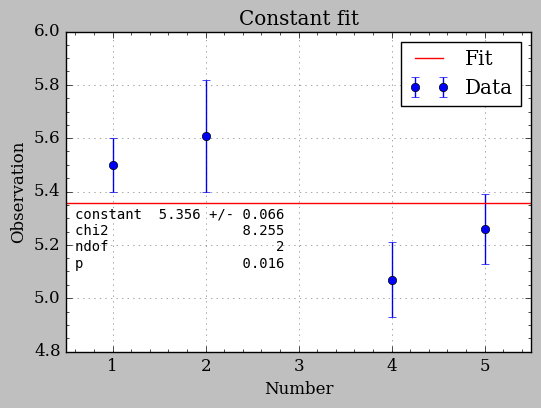

In [271]:
chi2_constant2 = Chi2Regression(constant, num2, obs2, unc2)
minuit2 = Minuit(chi2_constant2, a = 1)
minuit2.errordef = 1
minuit2.migrad()

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.errorbar(num2, obs2, yerr = unc2, fmt = 'o', label = 'Data')
ax.set(xlabel = 'Number', ylabel = 'Observation', title = 'Constant fit', xlim = (0.5, 5.5))
ax.axhline(minuit2.values[0], label = 'Fit', c = 'r')
ax.legend()

chi2, ndof, p = evaluate_chi2(minuit2, 3)

d = {
    'constant': [minuit2.values[0], minuit2.errors[0]],
    'chi2': chi2, 'ndof': ndof, 'p': p
}
text = nice_string_output(d, extra_spacing = 2, decimals = 3)
add_text_to_ax(0.02, 0.45, text, ax, fontsize = 10)

#fig.savefig('figures/222four.png')

In [272]:
#still low probability, but better
#removing number 4
mask3 = obs2 != 5.07
num3 = num2[mask3]
obs3 = obs2[mask3]
unc3 = unc2[mask3]

w3_mean = np.sum(obs3/unc3**2)/np.sum(1/unc3**2)
w3_unc = np.sqrt(1/np.sum(1/unc3**2))
print('The weighted mean is: ', w3_mean, ' with uncertainty: ', w3_unc)



The weighted mean is:  5.435622634270156  with uncertainty:  0.07415604000950009


In [273]:
print('The rms around the mean is', w2_unc*np.sqrt(4))
for i in range(4):
    z2 = (obs2[i] - w2_mean)/np.sqrt((w2_unc**2 * 5 + unc2[i]**2)) 
    print('The probality of ', obs2[i], ' is', 2*stats.norm.sf(np.abs(z2)))

The rms around the mean is 0.13106155877832762
The probality of  5.5  is 0.41539070631534647
The probality of  5.61  is 0.3203158398369167
The probality of  5.07  is 0.15888327882643294
The probality of  5.26  is 0.6258258730000625


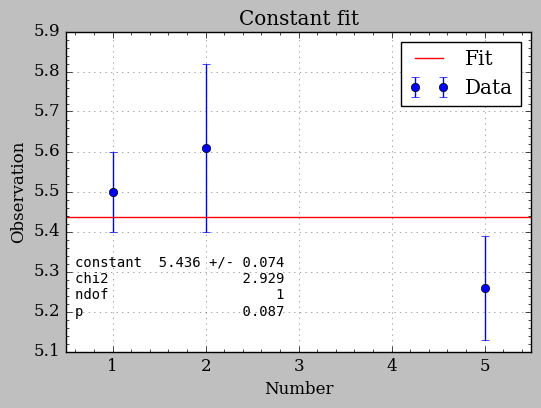

In [274]:
chi2_constant3 = Chi2Regression(constant, num3, obs3, unc3)
minuit3 = Minuit(chi2_constant3, a = 1)
minuit3.errordef = 1
minuit3.migrad()

fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.errorbar(num3, obs3, yerr = unc3, fmt = 'o', label = 'Data')
ax.set(xlabel = 'Number', ylabel = 'Observation', title = 'Constant fit', xlim = (0.5, 5.5))
ax.axhline(minuit3.values[0], label = 'Fit', c = 'r')
ax.legend()

chi2, ndof, p = evaluate_chi2(minuit3, 2)

d = {
    'constant': [minuit3.values[0], minuit3.errors[0]],
    'chi2': chi2, 'ndof': ndof, 'p': p
}
text = nice_string_output(d, extra_spacing = 2, decimals = 3)
add_text_to_ax(0.02, 0.3, text, ax, fontsize = 10)
#fig.savefig('figures/222three.png')


In [275]:
#2.2.3
#The true value is 5.514
#Performing a t-test of both samples
true_val = 5.514
t = abs(w_mean - true_val)/(w_unc)
p = 2*stats.t.sf(t, 4)
print('The t-value is: ', t, ' and the p-value is: ', p)

#removing num 3
t2 = abs(w2_mean - true_val)/(w2_unc)
p2 = 2*stats.t.sf(t2, 3)
print('The t-value is: ', t2, ' and the p-value is: ', p2)

#removing num 3 and 4
t3 = abs(w3_mean - true_val)/(w3_unc)
p3 = 2*stats.t.sf(t3, 2)
print('The t-value is: ', t3, ' and the p-value is: ', p3)

The t-value is:  3.908290010202592  and the p-value is:  0.017418972505054673
The t-value is:  2.4184642832633303  and the p-value is:  0.09429856557592477
The t-value is:  1.056924907530168  and the p-value is:  0.4013548841904704


In [276]:
#2.3
#2.3.1
#Error propagation using the same function as 2.1

a, e  = sp.symbols('a e')
err_sym = np.array(sp.symbols('sigma_a sigma_e'))
A = sp.pi*a**2*sp.sqrt(1-e**2)
A_func = sp.lambdify((a, e), A)
values = np.array([1.04, 0.71])
err_values = np.array([0.27, 0.12])

prop_A = Error_Prop(A, [a, e], err_sym, values, err_values, non_correlated)
display(prop_A.get_propEq())
print('The value of A is: ', A_func(*values), ' with uncertainty: ', prop_A.get_error())



sqrt(pi**2*a**4*e**2*sigma_e**2/(1 - e**2) + 4*pi**2*a**2*sigma_a**2*(1 - e**2))

The value of A is:  2.3928396994627694  with uncertainty:  1.3086861574841322


The value of A is:  2.4702161327890413  with uncertainty:  1.3226181287411245


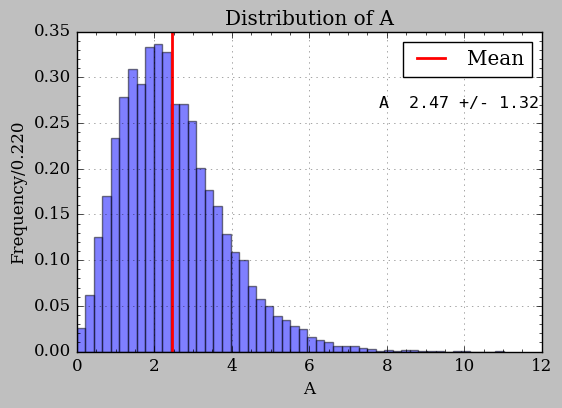

In [277]:
#The same error propagation can be done numerically

a_num = r.normal(1.04, 0.27, 10000)
e_num= r.normal(0.71, 0.12, 10000) 
e_invalid = e_num >= 1
e_num = e_num[~e_invalid]
a_num = a_num[~e_invalid]

A_num = A_func(a_num, e_num)
A_mean = np.mean(A_num)
A_unc = np.std(A_num)

print('The value of A is: ', A_mean, ' with uncertainty: ', A_unc)

#We plot the distribution of A
counts, bins = np.histogram(A_num, bins = 50, density = True)
binwidth = bins[1] - bins[0]
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
ax.hist(A_num, bins = 50, density = True, alpha = 0.5)
ax.set(xlabel = 'A', ylabel = f'Frequency/{binwidth:.3f}', title = 'Distribution of A')
ax.axvline(A_mean, label = 'Mean', c = 'r', linewidth = 2)
ax.legend()

d = {
    'A': [A_mean, A_unc]
}   
text = nice_string_output(d, extra_spacing = 2, decimals = 2)
add_text_to_ax(0.65, 0.8, text, ax, fontsize = 12)
#fig.savefig('figures/231.png');

The lower bound is:  5.087970817526375  with uncertainty:  1.3523295926287369
The upper bound is:  5.6513146837589  with uncertainty:  1.5020605184642173


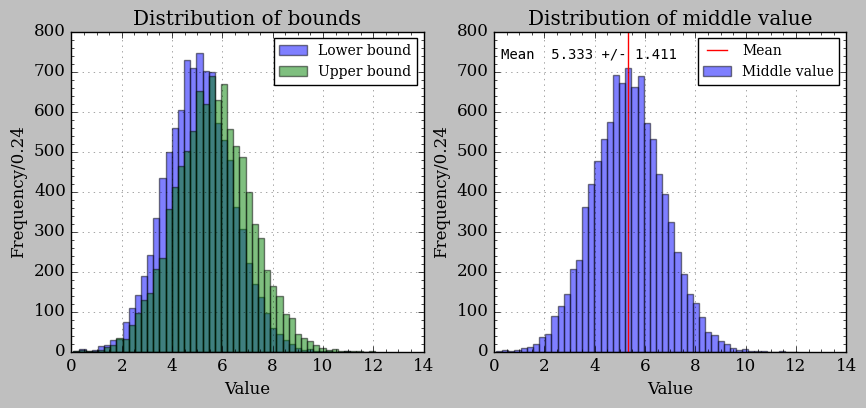

In [278]:
lower = 4*a*sp.sqrt(2-e**2)
upper = sp.pi*a*sp.sqrt(4-2*e**2)
lower_func = sp.lambdify((a, e), lower)
upper_func = sp.lambdify((a, e), upper)

lower_prop = Error_Prop(lower, [a, e], err_sym, values, err_values, non_correlated)
upper_prop = Error_Prop(upper, [a, e], err_sym, values, err_values, non_correlated)

print('The lower bound is: ', lower_func(*values), ' with uncertainty: ', lower_prop.get_error())
print('The upper bound is: ', upper_func(*values), ' with uncertainty: ', upper_prop.get_error())



lower_num = lower_func(a_num, e_num)
upper_num = upper_func(a_num, e_num)

#We plot the distribution of the lower and upper bound
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
bins_num = np.linspace(np.min(lower_num), np.max(upper_num), 50)
binwidth = bins_num[1] - bins_num[0]
ax[0].hist(lower_num, bins = bins_num, label = 'Lower bound', alpha = 0.5)
ax[0].hist(upper_num, bins = bins_num, label = 'Upper bound', alpha = 0.5);
ax[0].legend(fontsize = 10)
ax[0].set(xlabel = 'Value', ylabel = f'Frequency/{binwidth:.2f}', title = 'Distribution of bounds')

#We calculate the middle value and the uncertainty
middle = (lower_num + upper_num)/2
middle_unc = np.std(middle)
middle_mean = np.mean(middle)
ax[1].hist(middle, bins = bins_num, label = 'Middle value', alpha = 0.5)
ax[1].set(xlabel = 'Value', ylabel = f'Frequency/{binwidth:.2f}', title = 'Distribution of middle value')
ax[1].axvline(middle_mean, c = 'r', label = 'Mean')
ax[1].legend(fontsize = 10)
d = {
    'Mean': [middle_mean, middle_unc]
}
text = nice_string_output(d, extra_spacing = 2, decimals = 3)
add_text_to_ax(0.02, 0.95, text, ax[1], fontsize = 10)

#fig.savefig('figures/232.png')